# A sequential MNIST task in PyTorch
Sam Greydanus | 2018 | MIT License

In [65]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os, copy, time, pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils

try:
    import excitationbp as eb # see github.com/greydanus/excitationbp
except:
    print("you don't have excitation backprop installed.")
    print("\t-> most of this code will run fine")
    print("\t-> except the visualization part at the end")

# set up the workspace
reseed = lambda: np.random.seed(seed=0) ; ms = torch.manual_seed(0) # for reproducibility
reseed()

os.mkdir('figures') if not os.path.exists('figures') else None
os.mkdir('saved') if not os.path.exists('saved') else None

## Data loader

In the code below, I essentially wrap the PyTorch MNIST utility. We are going to show the network five MNIST examples (one at each of five time steps). The objective is to return a `1` if there was a zero in the sequence and a `0` otherwise.

Since each MNIST digit occur with a probability of $\frac{1}{10}$, in five examples we have a $5 \times \frac{1}{10} = \frac{1}{2}$ chance of seeing a zero in the sequence.

In [66]:
class SeqMnistLoader():
    def __init__(self):
        self.modes = modes = ['train', 'test']
        trans = transforms.Compose([transforms.ToTensor(),]) # transforms.Normalize((0.1307,), (0.3081,))
        self.dsets = {k: datasets.MNIST('./data', train=k=='train', download=True, transform=trans) for k in modes}
        self.loaders = {m: iter([]) for m in modes}
        self.batch_size = None
        self.tsteps = 5

    def next(self, batch_size, mode='train', sigma=0):
        if batch_size is not None and batch_size != self.batch_size:
            self.loaders[mode] = iter(torch.utils.data.DataLoader(
                                    self.dsets[mode], batch_size*self.tsteps, shuffle=True))
            self.batch_size = batch_size
        data = next(self.loaders[mode], None)
        if data is None or batch_size != data[0].shape[0]:
            self.loaders[mode] = iter(torch.utils.data.DataLoader(
                                    self.dsets[mode], batch_size*self.tsteps, shuffle=True))
            data = next(self.loaders[mode], None)
        X = data[0].view(self.tsteps, self.batch_size, 28**2).numpy()
        y = data[1].view(self.tsteps, self.batch_size).numpy()
        y = ((y == 0).sum(axis=0) > 0).astype(np.float32).reshape(-1,1) # 1 if sequence contains a zero, else 0
        return X, y

def accuracy(model, dataloader, samples=2000, mode='test'):
    X, y = dataloader.next(samples, mode=mode)
    model.eval()      # put model in evaluation mode
    y_hat = model.forward(X) # logits should be a numpy array
    model.train()     # put model in train mode
    return 100*( (y_hat>0.5) == (y > 0.5) ).sum()/samples # assumes y and y_hat are numpy arrays

## Visualize the Sequential MNIST task

Here are two concrete examples of the task

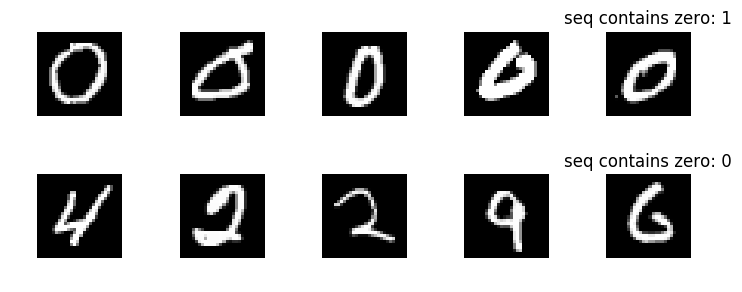

In [3]:
r, c = 2, 5
side = 1.5
f = plt.figure(figsize=[c*side, r*side], dpi=100)

dl = SeqMnistLoader()
X, y = dl.next(2, mode='test')

for j in range(r):
    for i in range(c):
        ix = j*c + i
        plt.subplot(r,c,ix+1)
        img = X[i][j].reshape(28,28)
        plt.imshow(img, cmap='gray')
        if i == c-1:
            plt.title('seq contains zero: {:.0f}'.format(y[j][0]))
[a.axis('off') for a in f.get_axes()]
plt.tight_layout() ; plt.show()

## Model

Our architecture is a linear (fully-connected) transformation from the input space ($28^2$ dimensions) to the hidden dimension (`hdim` dimensions) with a ReLU nonlinearity on top. The hidden activation gets sent through a GRU (or another RNN of your choice). I've looped over the time dimension to make the mechanics of the RNN explicit.

In this case, we only care about the final output of the GRU. Here we simple do a linear transformation from the hidden activation to a single value, which we squash somewhere between 0 and 1 using the sigmoid. We then regress on this value, trying to make it `1` when there was a one in the sequence and `0` otherwise.

In [4]:
class SeqMnistClassifier(nn.Module):
    def __init__(self, hdim=100):
        super(SeqMnistClassifier, self).__init__()
        self.linear1 = nn.Linear(28**2, hdim)
        self.rnn = nn.GRUCell(input_size=hdim, hidden_size=hdim)
        self.linear2 = nn.Linear(hdim, 1)
        self.hdim = hdim

    def forward(self, x):
        x = Variable(torch.Tensor(x)) if type(x) == np.ndarray else x # maybe convert to an autograd variable
        timesteps, batch, space = x.shape
        time_batch = timesteps*batch
        
        x = x.view(time_batch, space)
        h1 = F.relu(self.linear1(x))  # shape [batch*time x 28^2] -> [batch*time x hdim]
        h1 = h1.view(timesteps, batch, self.hdim)
        
        outputs = []
        hx = Variable(torch.zeros(batch, self.hdim))
        for t in range(timesteps):
            hx = self.rnn(h1[t], hx)
            outputs.append(hx)
            
        h2 = outputs[-1] # use torch.cat([outputs]) if you want to regress on all outputs
        
        h2 = h2.view(batch, self.hdim)
        h3 = F.sigmoid(self.linear2(h2))
        h3 = h3.view(batch, 1)
        
        return h3 if self.training else h3.data.numpy() # maybe return as a numpy array, else as a Variable

## Utility functions
For loading, saving, keeping a running mean of the loss

In [5]:
def to_pickle(thing, name): # save something
    with open('saved/{}.pkl'.format(name), 'wb') as handle:
        pickle.dump(thing, handle, protocol=pickle.HIGHEST_PROTOCOL)

def from_pickle(name): # load something
    thing = None
    with open('saved/{}.pkl'.format(name), 'rb') as handle:
        thing = pickle.load(handle)
    return thing

running_mean = lambda mean, update: update if mean is None else .99*mean + (1-.99)*update

## Hyperparameters
We'll use a trick to make our dictionary of hyperparameters and other training info look like an object. I'm doing this out of personal taste. Reasons to do it this way:

* Dictionaries are a fundamental Python data structure
 * everyone knows how to interact with dictionaries
 * this makes my work (maybe) easier to follow?
* Dictionaries are easy to save/load compared to objects
 * so loading a saved model plus its training metadata is easy
* Objects are easier to interact with
 * `info.global_step` is cleaner than `info['global_step']`
 * yes, I'm a bit of a perfectionist
    
By making a dictionary that looks like an object, we get the best of both worlds :)

In [6]:
info_dict = {'hidden_dim': 200,
        'lr': 1e-3,
        'batch_size': 25,
        'test_every': 100,
        'global_step': 0,
        'epochs': .25,
        'loss': [],
        'accuracy': [],
        'name': 'mnist-seq'}
info_dict['total_steps'] = int(info_dict['epochs']*60000/info_dict['batch_size'])

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
info = ObjectView(info_dict)

## Initialize everything

In this case, we just make a dataloader and a model. The optimizer is just SGD.

In [7]:
dataloader = SeqMnistLoader()
model = SeqMnistClassifier(info.hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=info.lr)
model.train() # put model in train mode

try:
    [model, info_dict] = from_pickle(info.name)
    info = ObjectView(info_dict)
    print('\t* loaded a model')
except:
    print('\t* no model to load')
    
acc = accuracy(model, dataloader, mode='test')
print('test accuracy: {:.2f}%'.format(acc))

	* loaded a model
test accuracy: 98.25%


## Train

We define $\mathcal{L}$ to be L2 loss:
$$ \operatorname*{arg\,min}_\theta \mathcal{L} \quad \textrm{where} \quad \mathcal{L} = \frac{1}{N}\sum^N (\hat y-y)^2 $$
In the equation above, $N$ is the minibatch size, $y$ is the supervised training label and $\hat y$ is the softmax distribution of the classifier.

In [8]:
start_t = print_t = time.time()
run_loss = None
test_acc = train_acc = 50
for step in range(info.global_step+1, info.total_steps):
    
    X, y = dataloader.next(info.batch_size)  # get a minibatch
    y_hat = model(X)                         # forward pass
    loss = (y_hat - Variable(torch.Tensor(y))).pow(2).mean()    # this is the L2 loss function
    loss.backward() ; optimizer.step() ; optimizer.zero_grad() # get grads, apply with optimizer
    
    info.loss += [loss.data.view(-1)[0]]
    run_loss = running_mean(run_loss, loss.data.view(-1)[0])
    info.global_step = step
    if time.time() - print_t > .2:
        print_t = time.time()
        print('\tstep {}/{} | elapsed {:.1f}s | loss {:.4f} | test_acc {:.2f}% | train_acc {:.2f}%'
              .format(step, info.total_steps, time.time()-start_t, run_loss, test_acc, train_acc), end='\r')
    if step % info.test_every == 0 or step == info.total_steps-1:
        test_acc = accuracy(model, dataloader, samples=2000, mode='test')
        train_acc = accuracy(model, dataloader, samples=2000, mode='train')
        info.accuracy += [[test_acc, train_acc].copy()]
        
        to_pickle([model, info_dict], info.name) # save model and train stats

## Visualize examples

With the help of excitation backprop, we can see that the model is generally "looking for" inputs that contain a handwritten zero.

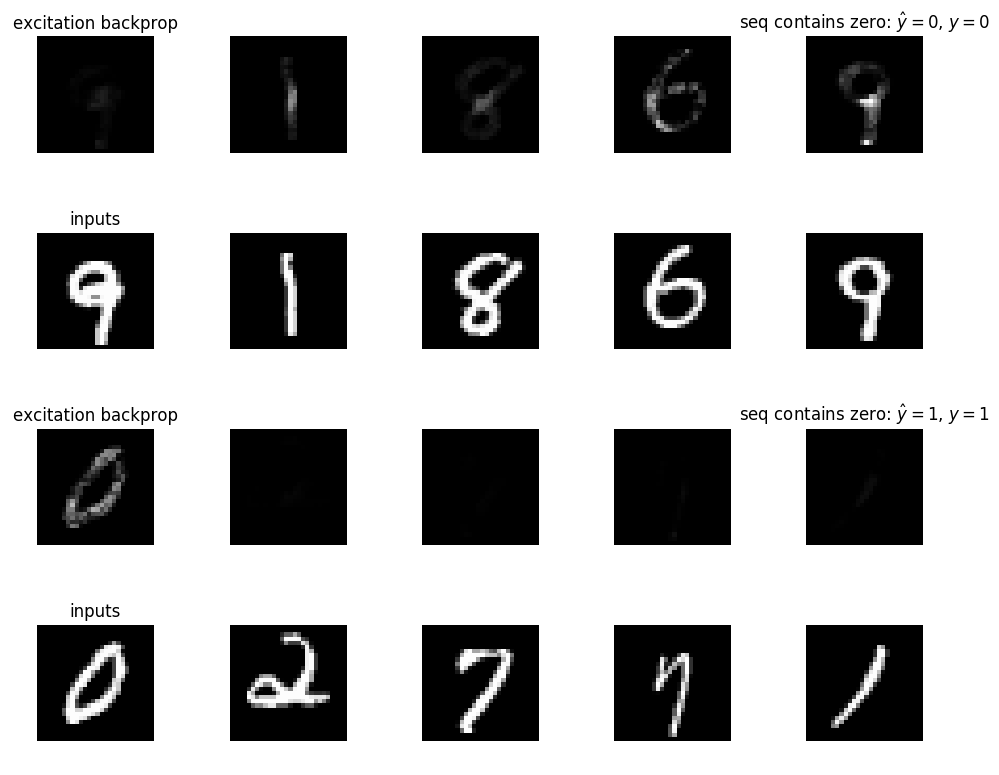

In [58]:
r, c = 4, 5
side = 2
f = plt.figure(figsize=[c*side, r*side], dpi=100)

X, y = dataloader.next(batch_size=int(r/2), mode='test')

# compute excitation backprop for correct label (see EB tutorial @ github.com/greydanus/excitationbp)
eb.use_eb(True)
inputs = Variable(torch.Tensor(X))
zero_id = 0
prob_outputs_zero = Variable(torch.zeros(1,1)) ; prob_outputs_zero.data[0:1,zero_id] += 1
prob_inputs_zero = eb.excitation_backprop(model, inputs, prob_outputs_zero, contrastive=True)
ebX = prob_inputs_zero.view(inputs.shape).data.abs().numpy()

# evaluate model as usual
model.eval()
y_hat = model(X)

# plot it
for j in range(r):
    for i in range(c):
        ix = j*c + i
        plt.subplot(r,c,ix+1)
        batch_ix = int(j/2)
        if j%2==0:
            if i==0: plt.title('excitation backprop')
            img = ebX[i][batch_ix].reshape(28,28)
            plt.imshow(img, cmap='gray')
            plt.clim(ebX.min(),ebX.max())
            if i == c-1:
                plt.title('seq contains zero: $\hat y={:.0f}$, $y={:.0f}$'.format(y_hat[batch_ix][0], y[batch_ix][0]))
        else:
            if i==0: plt.title('inputs')
            img = X[i][batch_ix].reshape(28,28)
            plt.imshow(img, cmap='gray')
            plt.clim(0,1)
[a.axis('off') for a in f.get_axes()]
plt.tight_layout() ; plt.show()
# f.savefig('figures/{}-example.png'.format(info_dict['name']))

## Visualize train stats

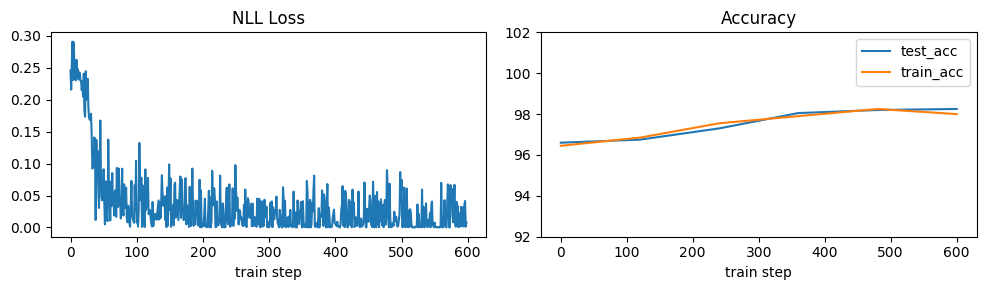

In [59]:
f = plt.figure(figsize=[10,3], dpi=100)
plt.subplot(1,2,1)
plt.plot(info_dict['loss'], label=info_dict['name'])
plt.title('NLL Loss') ; plt.xlabel('train step')

plt.subplot(1,2,2)
test_acc, train_acc = np.stack(info_dict['accuracy']).T
train_step_list = np.linspace(0,info_dict['test_every']*len(test_acc), len(test_acc))
plt.plot(train_step_list, test_acc, label='test_acc')
plt.plot(train_step_list, train_acc, label='train_acc')
plt.title('Accuracy') ; plt.xlabel('train step')
plt.ylim(92,102)

plt.legend()
plt.tight_layout() ; plt.show()
f.savefig('figures/{}-stats.png'.format(info_dict['name']))